In [16]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from data_preprocessing import get_data

In [17]:
X_train, y_train, X_test, y_test, y_scaler, train_loader, test_loader = get_data(
            timestep = 10,
            batch_size = 64,
            y_name = 'Closing price',
            train_size = 6627,
            path = "Data/SSE000001.csv")
y_test = y_scaler.inverse_transform(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([6618, 10, 8]) torch.Size([6618, 1]) torch.Size([490, 10, 8]) (490, 1)


In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    print ("GPU device not found.")

mps


# CNN

In [28]:
class CNN(nn.Module):
    def __init__(self, input_size = 8, output_size = 32):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # Convolutional layer parameters from the table
        self.conv1d = nn.Conv1d(in_channels= self.input_size, out_channels= self.output_size, kernel_size= 1, padding="same")
        
        # Activation function
        self.tanh = nn.Tanh()

        # Pooling
        self.maxpool1d = nn.MaxPool1d(kernel_size= 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layer
        x = self.conv1d(x)
        x = self.tanh(x)
        x = self.maxpool1d(x)
        x = self.relu(x)
        return x


# BILSTM

In [29]:
class BILSTM(nn.Module):
    def __init__(self, input_size = 8, num_layers = 1, hidden_size = 64):
        super(BILSTM, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size = self.input_size, 
                             hidden_size = self.hidden_size,
                             num_layers = self.num_layers,
                             batch_first = True,
                             bidirectional = True)
        
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(self.hidden_size * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)


        x, _ = self.lstm(x, (h0, c0))
        # x = self.tanh(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = x[:, -1, :]

        return output

### CNN-BILSTM

In [30]:
class CNN_BILSTM(nn.Module):
    def __init__(self, cnn_input_size = 8, cnn_output_size = 32, bi_input_size = 32, bi_num_layer = 1, bi_hidden_size = 64):
        super(CNN_BILSTM, self).__init__()
        
        self.cnn = CNN(input_size = cnn_input_size, 
                       output_size = cnn_output_size)
        
        self.bilstm = BILSTM(input_size = bi_input_size, 
                             num_layers = bi_num_layer,
                             hidden_size = bi_hidden_size)  # Assuming the CNN output has 32 features

    def forward(self, x):
        # CNN expects the channels in the second dimension
        x = x.permute(0, 2, 1)  #[64, 8, 10]
        x = self.cnn(x)
        # Permute back to (batch, seq_len, features) for the LSTM
        x = x.permute(0, 2, 1)
        # Reshape x to fit BiLSTM input requirements
        x = self.bilstm(x)
        return x

## Define model

In [88]:
# setting hyperparameters
batch_size = 64
time_steps = 10
cnn_input_size = 8
cnn_output_size = 32
bi_input_size = 32
bi_num_layers = 1
bi_hidden_size = 64
learning_rate = 0.0001
num_epoch = 100

model = CNN_BILSTM(cnn_input_size = cnn_input_size,
                   cnn_output_size = cnn_output_size,
                   bi_input_size = bi_input_size,
                   bi_num_layer = bi_num_layers,
                   bi_hidden_size = bi_hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.L1Loss() # Mean Absolute Error

## Train

In [89]:
model.train(True)
training_loss = []
for epoch in range(num_epoch):
    running_loss = 0
    for batch_index, batch in enumerate(train_loader):
        X, y_true = batch[0].to(device), batch[1].to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            display.clear_output(wait=True)
            print('Epoch {0}, Batch {1}, Loss: {2:.6f}'.format(epoch, batch_index, loss.item()))
    training_loss.append(running_loss)
    # if loss.item() < 0.016:
        # break
model.train(False)

Epoch 99, Batch 100, Loss: 0.023419


CNN_BILSTM(
  (cnn): CNN(
    (conv1d): Conv1d(8, 32, kernel_size=(1,), stride=(1,), padding=same)
    (tanh): Tanh()
    (maxpool1d): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (bilstm): BILSTM(
    (lstm): LSTM(32, 64, num_layers=2, batch_first=True, bidirectional=True)
    (tanh): Tanh()
    (fc1): Linear(in_features=128, out_features=16, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)

## Evaluation

In [90]:
with torch.no_grad():
    y_train_pred = model(X_train.to(device)).to('cpu')
    y_test_pred = model(X_test.to(device)).to('cpu')

y_test_pred = y_scaler.inverse_transform(y_test_pred)

train_mse = mean_squared_error(y_train_pred, y_train, squared=False)
test_mse = mean_squared_error(y_test_pred, y_test, squared=False)

train_mae = mean_absolute_error(y_train_pred, y_train)
test_mae = mean_absolute_error(y_test_pred, y_test)

train_r2 = r2_score(y_train_pred, y_train)
test_r2 = r2_score(y_test_pred, y_test)

print("Train RMSE: {0:.6f}; Test RMSE {1:.6f}\n".format(train_mse, test_mse))
print("Train  MAE: {0:.6f}; Test  MAE {1:.6f}\n".format(train_mae, test_mae))
print("Train  R^2: {0:.6f}; Test  R^2 {1:.6f}\n".format(train_r2, test_r2))

Train RMSE: 0.040718; Test RMSE 43.307657

Train  MAE: 0.024318; Test  MAE 30.802969

Train  R^2: 0.998337; Test  R^2 0.956623



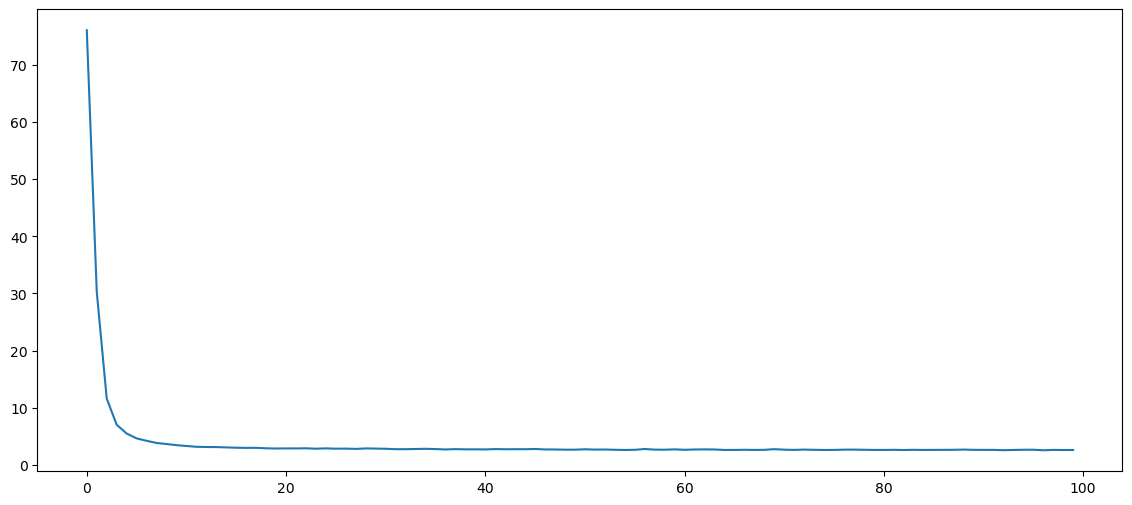

In [91]:
plt.figure(figsize=(14, 6))
plt.plot(training_loss)
plt.show()

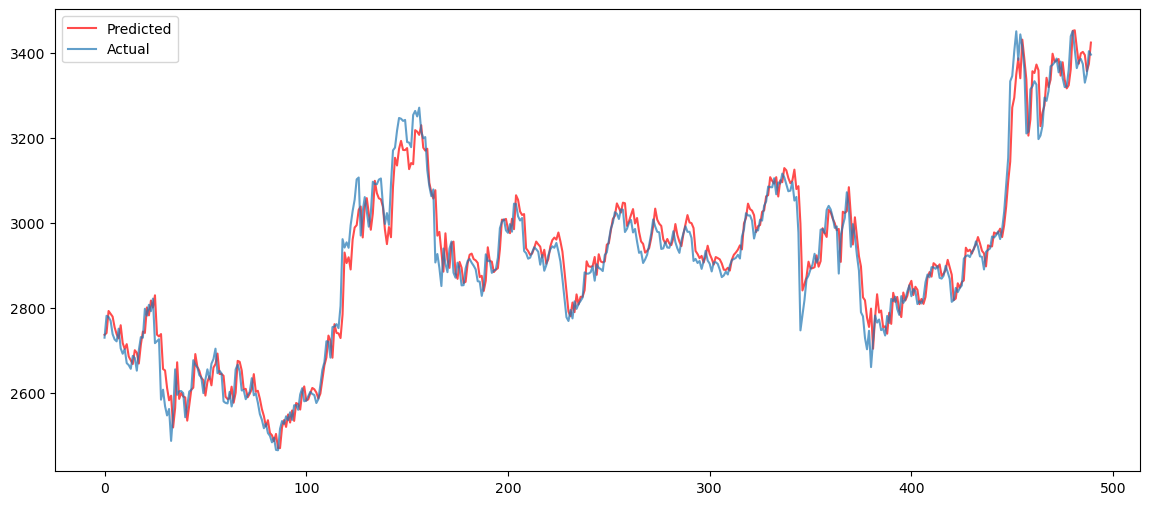

In [92]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_pred, label='Predicted', alpha=0.7, color='red')
plt.plot(y_test, label='Actual', alpha=0.7)
plt.legend()
plt.show()

#### Save the model

In [ ]:
path = "models/CNNBI_{0}Epoch_{1}Lr_{2}-{3}-({4}hidden_size,{5}layer)-1.pt".format(num_epoch, learning_rate, cnn_input_size, cnn_output_size, bi_hidden_size, bi_num_layers)
torch.save(model.state_dict(), path)

#### Load the model

In [ ]:
# model = BILSTM()
# model.load_state_dict(torch.load(path))
# model.eval()